### Importing libraries

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

### Loading data and EDA

In [47]:
# Load dataset
df = pd.read_csv('input/skincare.csv')

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       1438 non-null   int64 
 1   Title            1438 non-null   object
 2   Product          1438 non-null   object
 3   Category         1438 non-null   object
 4   Brand            1438 non-null   object
 5   Skin_Type        1438 non-null   object
 6   Number of items  1438 non-null   int64 
 7   Sold By          1231 non-null   object
 8   Price            1438 non-null   int64 
 9   Link             1438 non-null   object
dtypes: int64(3), object(7)
memory usage: 112.5+ KB


In [51]:
df.head()

,Unnamed: 0,Title,Product,Category,Brand,Skin_Type,Number of items,Sold By,Price,Link
0,0,"Nivea Soft Light Moisturizer For Face,...",Moisturizer,SKINCARE,Nivea,All,1,AIR SALES,372,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
1,1,"Nivea Soft Playful Peach, Light Moistu...",Moisturizer,SKINCARE,Nivea,All,1,RK World Infocom Pvt Ltd,226,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
2,2,"Nivea Soft Light Moisturizer For Face,...",Moisturizer,SKINCARE,Nivea,Dry,1,MURALI RETAILS,103,https://www.amazon.in/sspa/click?ie=UTF8&spc=M...
3,3,Biotique Morning Nectar Flawless Skin ...,Moisturizer,SKINCARE,Biotique,Combination,1,RK World Infocom Pvt Ltd,240,https://www.amazon.in/Biotique-Morning-Nectar-...
4,4,Minimalist Marula Oil 5% Face Moisturi...,Moisturizer,SKINCARE,Minimalist,Dry,1,Minimalist Inc,284,https://www.amazon.in/Minimalist-Moisturizer-H...


In [52]:
print(df.shape)

(1438, 10)


In [53]:
print(df.describe())

        Unnamed: 0  Number of items         Price
count  1438.000000      1438.000000   1438.000000
mean    718.500000         1.563978    619.605702
std     415.259156        13.273306   1481.257665
min       0.000000         1.000000     45.000000
25%     359.250000         1.000000    199.000000
50%     718.500000         1.000000    296.500000
75%    1077.750000         1.000000    476.000000
max    1437.000000       500.000000  23617.000000


In [54]:
print(df.isnull().sum())

Unnamed: 0           0
Title                0
Product              0
Category             0
Brand                0
Skin_Type            0
Number of items      0
Sold By            207
Price                0
Link                 0
dtype: int64


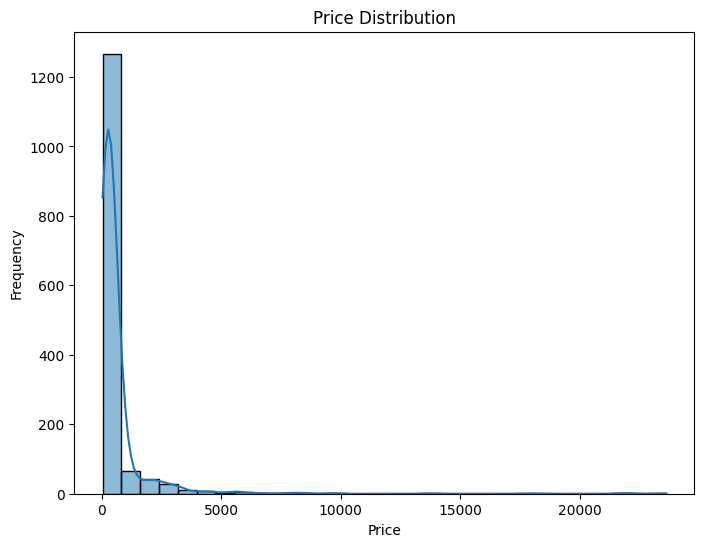

In [57]:
# Histogram for Price
plt.figure(figsize=(8, 6))
sns.histplot(df['Price'], kde=True, bins=30)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

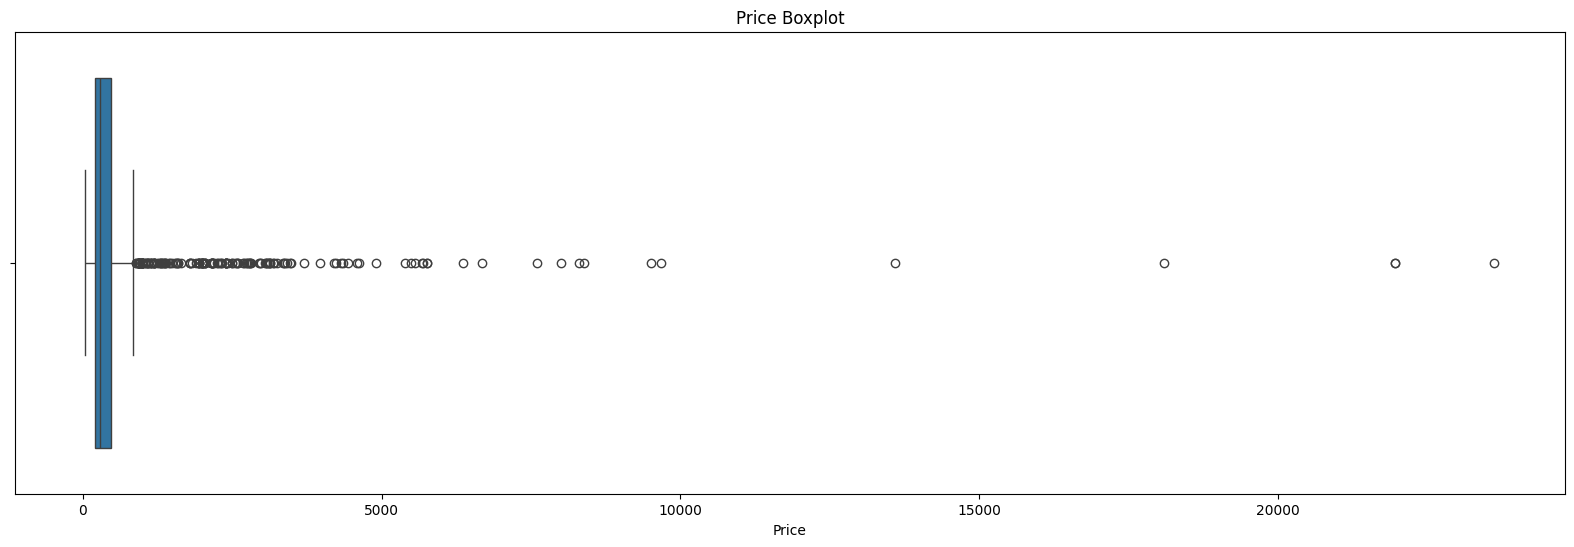

In [58]:
# Boxplot for Price to identify outliers
plt.figure(figsize=(20, 6))
sns.boxplot(data=df, x='Price')
plt.title('Price Boxplot')
plt.xlabel('Price')
plt.show()

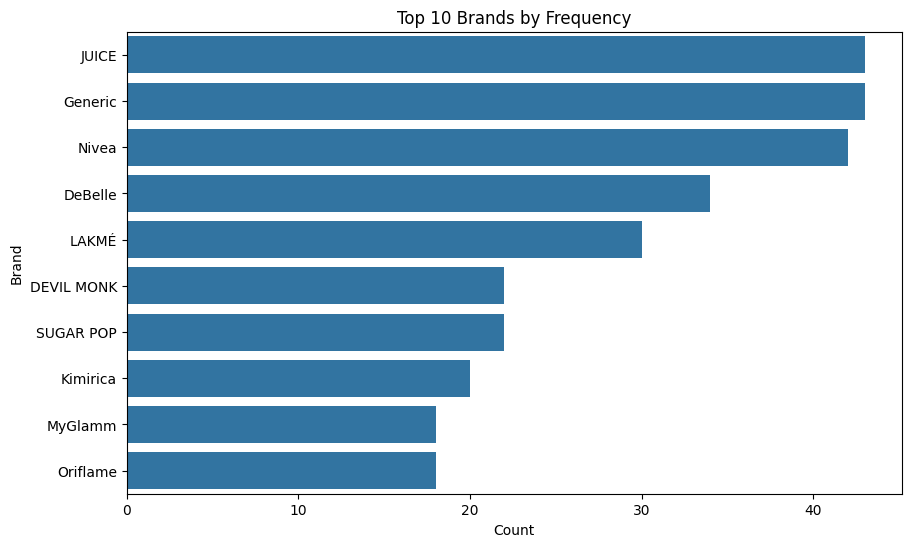

In [59]:
# Bar plot for Top 10 Brands
plt.figure(figsize=(10, 6))
top_10_brands = df['Brand'].value_counts().nlargest(10)
sns.barplot(x=top_10_brands.values, y=top_10_brands.index)
plt.title('Top 10 Brands by Frequency')
plt.xlabel('Count')
plt.ylabel('Brand')
plt.show()

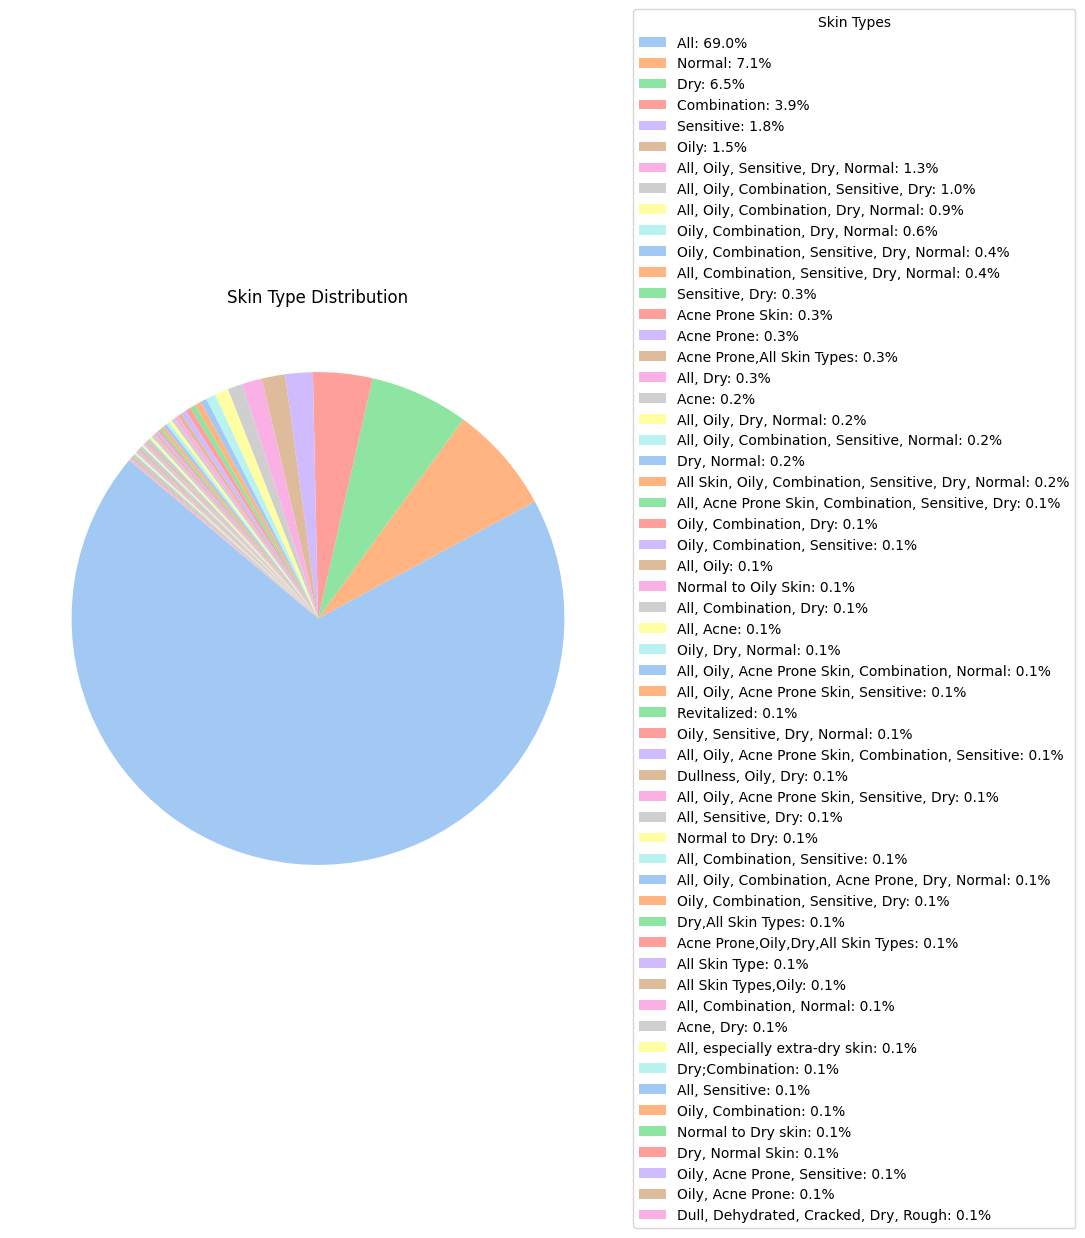

In [60]:
# Pie chart for Skin_Type with percentages in the legend
plt.figure(figsize=(8, 8))
skin_type_counts = df['Skin_Type'].value_counts()

# Calculate the percentages for each skin type
percentages = (skin_type_counts.values / skin_type_counts.values.sum()) * 100
legend_labels = [f"{label}: {percent:.1f}%" for label, percent in zip(skin_type_counts.index, percentages)]

# Create the pie chart without labels
wedges, _ = plt.pie(
    skin_type_counts.values, 
    startangle=140, 
    colors=sns.color_palette('pastel')
)

# Add a legend with the percentages
plt.legend(wedges, legend_labels, title='Skin Types', loc='center left', bbox_to_anchor=(1, 0.5))

# Add a title and show the plot
plt.title('Skin Type Distribution')
plt.show()

### Data Preprocessing

In [25]:
# # Preprocessing: One-hot encode the 'Skin_Type' column
encoder = OneHotEncoder()
skin_type_encoded = encoder.fit_transform(df[['Skin_Type']]).toarray()

# Data Preprocessing
# Convert categorical variables into numerical variables
le = LabelEncoder()
df['Brand'] = le.fit_transform(df['Brand'])
df['Skin_Type'] = le.fit_transform(df['Skin_Type'])
df['Sold By'] = le.fit_transform(df['Sold By'])
df['Category'] = le.fit_transform(df['Category'])
df['Product'] = le.fit_transform(df['Product'])

# Define the target variable
target = df['Skin_Type']

# Define the features
features = df.drop(['Skin_Type', 'Title', 'Link'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


### Recommendation using Collaborative Filtering

In [24]:
# # Preprocessing: One-hot encode the 'Skin_Type' column
encoder = OneHotEncoder()
skin_type_encoded = encoder.fit_transform(df[['Skin_Type']]).toarray()

# Compute cosine similarity for the skin types
cosine_sim = cosine_similarity(skin_type_encoded)

# Function to recommend products
def recommend_products(skin_type, df, cosine_sim, num_recommendations=5):
    # Get the index of the first product matching the skin type
    skin_type_indices = df.index[df['Skin_Type'] == skin_type].tolist()
    if not skin_type_indices:
        print(f"No products found for skin type: {skin_type}")
        return pd.DataFrame()

    # Take the first matching index for similarity computation
    idx = skin_type_indices[0]
    
    # Calculate similarity scores for all products
    similarity_scores = cosine_sim[idx]
    
    # Sort indices by similarity scores in descending order
    sorted_indices = similarity_scores.argsort()[::-1]
    
    # Exclude the current product itself and pick the top recommendations
    recommended_indices = [i for i in sorted_indices if i != idx][:num_recommendations]
    
    # Retrieve the recommended products
    recommendations = df.iloc[recommended_indices][['Title', 'Skin_Type', 'Brand', 'Price', 'Link']]
    return recommendations

# Example usage
skin_type_to_recommend = 'Dry'  # Change to the desired skin type
recommended_products = recommend_products(skin_type_to_recommend, df, cosine_sim, num_recommendations=5)

# Display the recommendations
print(f"Recommended products for '{skin_type_to_recommend}' skin type:")
print(recommended_products)


Recommended products for 'Dry' skin type:
                                                  Title Skin_Type       Brand  \
1129          O'Keeffe's K0290004-6 Working Hands Ha...       Dry  O'Keeffe's   
1122          Nivea Body Lotion For Extremely Dry Sk...       Dry       Nivea   
941           Neutrogena Concentrated Non Scented Ha...       Dry  Neutrogena   
281           Vaseline Intensive Care Aloe Fresh Hyd...       Dry    Vaseline   
127           Lakme Peach Milk Soft Creme Moisturize...       Dry       LAKMÉ   

      Price                                               Link  
1129   8304  https://www.amazon.in/OKeeffes-Working-Hands-C...  
1122    251  https://www.amazon.in/Nivea-Extremely-Natural-...  
941     530  https://www.amazon.in/Neutrogena-Concentrated-...  
281     242  https://www.amazon.in/Vaseline-Intensive-Hydra...  
127     209  https://www.amazon.in/Lakm%C3%A9-Peach-Milk-So...  


### SVM

In [31]:
# Model Training and Evaluation
# SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
print("SVM Accuracy:\n", accuracy_score(y_test, svm_predictions))

# KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
print("KNN Accuracy:\n", accuracy_score(y_test, knn_predictions))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print("Random Forest Classification Repor:\n", accuracy_score(y_test, rf_predictions))

SVM Classification Report:
 0.7152777777777778
KNN Classification Report:
 0.6909722222222222
Random Forest Classification Report:
 0.75


In [32]:
# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

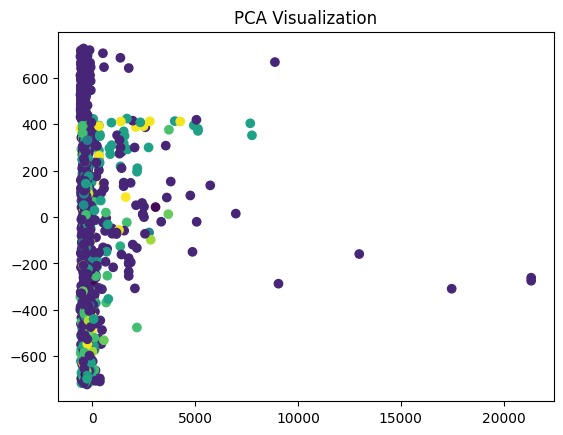

In [43]:
# Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train)
plt.title("PCA Visualization")
plt.show()

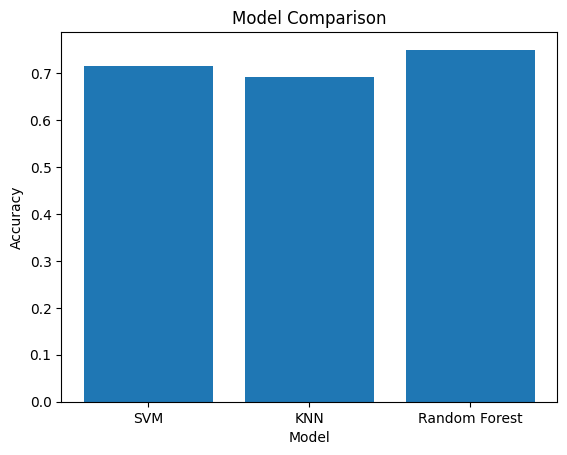

In [37]:
# Compare the models
models = ['SVM', 'KNN', 'Random Forest']
accuracies = [accuracy_score(y_test, svm_predictions), accuracy_score(y_test, knn_predictions), accuracy_score(y_test, rf_predictions)]
plt.bar(models, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()